# No Limit Texas Hold'em Deep Q learning

This notebook is using modern deep learning libraries to try to solve No Limit Hold'em (NLH). There are AIs developed that have beaten world class players in heads-up (2 players) NLH. We still have a long way to go here.

To run the notebook you need to install the https://github.com/VinQbator/holdem fork of the holdem library. A lot of bugfixes and changes were needed to effectively run the environment for deep learning.

Also keras-rl should be installed from https://github.com/VinQbator/keras-rl. Sorry for the inconvenience.

Rest of the libraries are found from pip as listed in the following imports section.

A lot of heavy lifting is in .py files adjacent to the notebook to keep the notebook clean.

Most of the effort here is put into building a framework to enable more serious development in the future.

# Imports

In [1]:
from players.atm import ATM
from players.ai_player import AIPlayer
from players.random_player import RandomPlayer
from training_env import TrainingEnv
from agents import build_dqn_agent, fit_agent, train_loop, load_agent_weights
from models import simple_model, complex_model
from util import visualize_history, use_jupyter, set_on_demand_memory_allocation
from helpers.poker_history import PokerHistory

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
set_on_demand_memory_allocation()

In [4]:
use_jupyter()

# Feature Engineering

### Some of the stuff that is happening in the wrapper layer for the holdem gym environment.
* Positions are one-hot encoded
* Pot and bet sizes are normalized to 100 big blinds
* Hand ranking either normalized or one-hot encoded
* Cards are one-hot encoded

# Action space

### Essentially infinite or at least large action space is split up into

* Base moves like FOLD/CALL/CHECK

* And few common bet/raise sizes relative to the pot size: 1/5, 1/4, 1/3, 2/5, 1/2, 3/5, 2/3, 3/4, 4/5, 1, 4/3, 5/3, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100

In [ ]:
# How many players in table
NUMBER_OF_SEATS = 2
# Max betsize in simulation environment (shouldn't really matter with discrete relative to pot sizing)
MAX_BET = 100000
# 'norm' (normalized) or 'one-hot' < how to encode player hand ranking from 7642 unique values
RANK_ENCODING = 'norm'

WINDOW = 10
MODEL = complex_model

FIRST_RUN_STEPS = 100000
SECOND_RUN_STEPS = 100000
THIRD_RUN_STEPS = 100000
THIRD_RUN_ITERATIONS = 50
BENCHMARK_EPISODES = 500000

In [ ]:
# Lets start with playing against player that always calls or checks based on which is currently valid move
# Hopefully this will teach the agent something about hand strength at least
env = TrainingEnv.build_environment(ATM(), NUMBER_OF_SEATS, debug=False)

##### First lets train a simple model with 1 step sequences against an opponent who always calls or folds based on whichever move is valid

No need to train against it for long - we just want to learn some basics

In [ ]:
model = MODEL(WINDOW, env.n_observation_dimensions, env.n_actions)
print(model.summary())
# window_length - how many timesteps to look into past (will multiply observation space by this, be careful)
# enable_double_dqn - https://arxiv.org/pdf/1509.06461.pdf
# enable_dueling_network - ???
# train_interval - every how many steps to run a train cycle (or if in 0...1 range, the soft update weight)
# n_warmup_steps - how many steps to run without training
# batch_size - number of (s, a, G) triplets to train on in one training cycle (as a batch)
# gamma - future reward discount essentially
# memory_interval - how often to add last step to memory buffer (discarding every other)

agent = build_dqn_agent(model, env.n_actions, window_length=WINDOW, target_model_update=0.001, 
                        enable_double_dqn=True, enable_dueling_network=True, dueling_type='avg', 
                        train_interval=100, n_warmup_steps=50, batch_size=32, gamma=.99, memory_interval=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16224256  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
__________

In [ ]:
# Let's play for 100000 steps (decisions made by AI)
agent, hist = fit_agent(agent, env, FIRST_RUN_STEPS, debug=False) 

Training for 100000 steps ...
Interval 1 (0 steps performed)
20000/20000 [==============================] - 485s 24ms/step - reward: 0.2360
6898 episodes - episode_reward: 0.684 [-74.000, 73.800] - loss: 90.688 - mean_absolute_error: 0.778 - mean_q: 1.191 - money_won: -0.136

Interval 2 (20000 steps performed)
20000/20000 [==============================] - 491s 25ms/step - reward: 0.2751
6935 episodes - episode_reward: 0.793 [-74.800, 72.200] - loss: 99.527 - mean_absolute_error: 0.788 - mean_q: 1.176 - money_won: 0.810

Interval 3 (40000 steps performed)
20000/20000 [==============================] - 494s 25ms/step - reward: 0.2948
6883 episodes - episode_reward: 0.857 [-75.800, 74.000] - loss: 99.238 - mean_absolute_error: 0.794 - mean_q: 1.185 - money_won: 1.347

Interval 4 (60000 steps performed)
20000/20000 [==============================] - 487s 24ms/step - reward: 0.2866
6863 episodes - episode_reward: 0.835 [-68.400, 76.200] - loss: 90.966 - mean_absolute_error: 0.758 - mean_q:

## As we can see the simple network was able to learn a bit and achieve a positive winrate

NB! The Winrate and Winnings plots show $ not big blinds. (Didn't want to run the notebook again, fixed in code)

Total $ won: 139952
Winrate BB/100: 16.359566322803122
Total hands: 34219


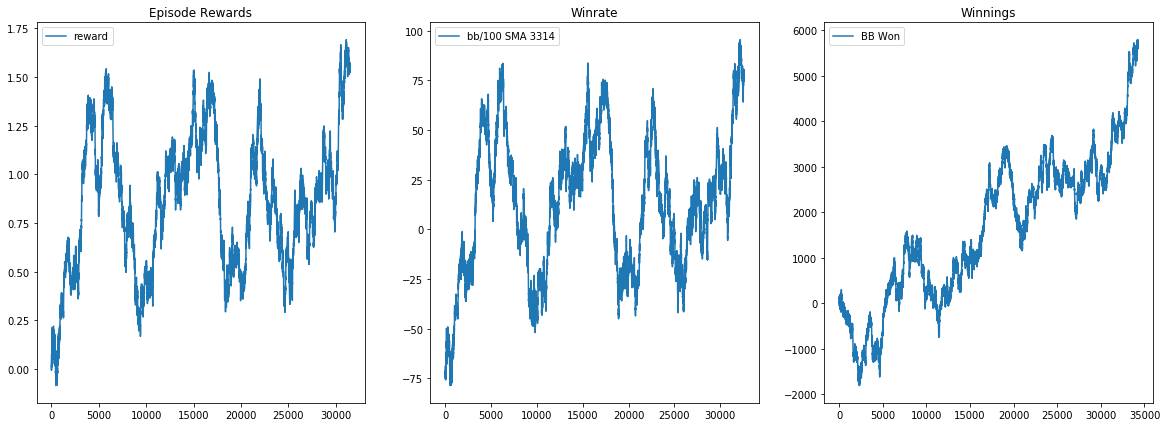

In [ ]:
# Some plots of how the training session went
visualize_history(hist)

### Hand history rendering is still a bit wonky, but it's clear that the bot is not making too smart choices

In [ ]:
# Let's evaluate our agent for 5 episodes (hands).
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 166
last action by player 1:
_ check
community:
- [3♠],[K♠],[4♣],[  ],[  ] 
players:
0 SB [K♣],[J♠] stack: 1917
1 BB [3♣],[Q♣] stack: 1917
total pot: 718
last action by player 1:
_ check
community:
- [3♠],[K♠],[4♣],[5♠],[  ] 
players:
0 SB [K♣],[J♠] stack: 1641
1 BB [3♣],[Q♣] stack: 1641
total pot: 3110
last action by player 1:
_ check
community:
- [3♠],[K♠],[4♣],[5♠],[5♦] 
players:
0 SB [K♣],[J♠] stack: 445
1 BB [3♣],[Q♣] stack: 445
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [3♠],[K♠],[4♣],[5♠],[5♦] 
players:
0 SB [K♣],[J♠] stack: 2400
1 BB [3♣],[Q♣] stack: 1600
Episode 1: reward: 17.000, steps: 4
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [6♥],[A♦] stack: 3080
1 SB [4♣],[6♠] stack: 920
Episode 2: reward: 43.600, steps: 1
total pot: 4000
last action by player 1:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 SB [2♥]

# Lets now play against opponent who makes totally random moves

In [ ]:
# Lets play against our bot with totally random moves now
# Hopefully it teaches the agent at least something about how to act on wide range of situations
env = TrainingEnv.build_environment(RandomPlayer(), NUMBER_OF_SEATS, debug=False)

In [ ]:
# Train for playing against RandomPlayer
agent, hist = fit_agent(agent, env, SECOND_RUN_STEPS, False, hist)

Training for 100000 steps ...
Interval 1 (0 steps performed)
20000/20000 [==============================] - 475s 24ms/step - reward: 0.1107
9304 episodes - episode_reward: 0.238 [-77.640, 79.360] - loss: 136.386 - mean_absolute_error: 0.831 - mean_q: 1.107 - money_won: -5.372

Interval 2 (20000 steps performed)
20000/20000 [==============================] - 464s 23ms/step - reward: 0.2663
9345 episodes - episode_reward: 0.570 [-77.000, 76.400] - loss: 139.795 - mean_absolute_error: 0.838 - mean_q: 1.105 - money_won: -1.519

Interval 3 (40000 steps performed)
20000/20000 [==============================] - 476s 24ms/step - reward: 0.4593
9313 episodes - episode_reward: 0.986 [-77.200, 78.400] - loss: 135.462 - mean_absolute_error: 0.816 - mean_q: 1.089 - money_won: 3.333

Interval 4 (60000 steps performed)
20000/20000 [==============================] - 474s 24ms/step - reward: 0.4707
9306 episodes - episode_reward: 1.012 [-75.200, 79.280] - loss: 125.876 - mean_absolute_error: 0.825 - me

# Our winrate has increased even if the opponent is not totally predictable

Total $ won: 114104
Winrate BB/100: 5.667581428269859
Total hands: 80531


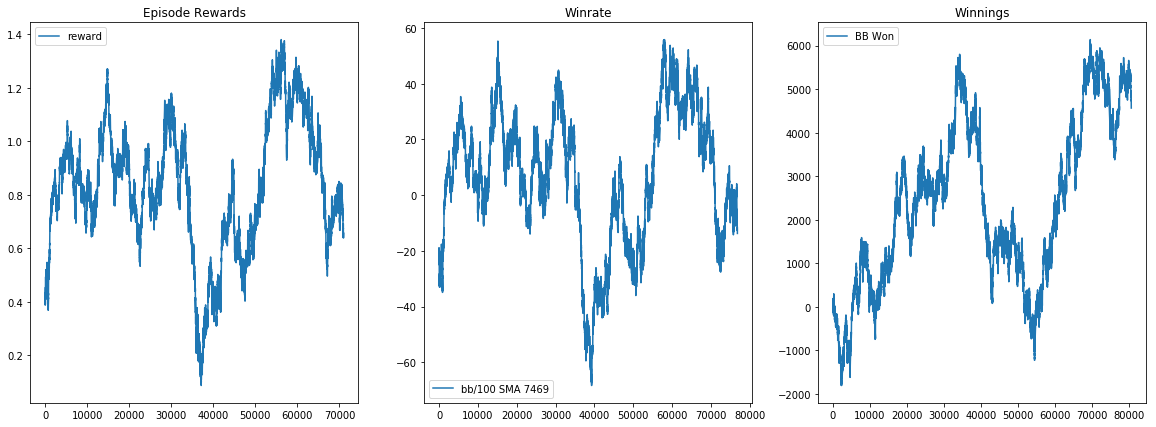

In [ ]:
visualize_history(hist)

# Hand history shows that AI is still making quite random moves

In [ ]:
agent.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
total pot: 0
last action by player 1:
x fold
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 SB [6♥],[A♣] stack: 1975
1 BB [T♠],[J♠] stack: 1990
Episode 1: reward: 0.000, steps: 1
total pot: 2525
last action by player 1:
^ raise, current bet: 2000
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [T♦],[A♠] stack: 1475
1 SB [3♣],[J♣] stack: 0
total pot: 4000
last action by player 0:
- call, current bet: 0
community:
- [  ],[  ],[  ],[  ],[  ] 
players:
0 BB [T♦],[A♠] stack: 2640
1 SB [3♣],[J♣] stack: 1360
Episode 2: reward: 26.000, steps: 2
total pot: 3125
last action by player 1:
^ raise, current bet: 875
community:
- [7♣],[4♣],[T♠],[  ],[  ] 
players:
0 SB [4♠],[K♦] stack: 875
1 BB [T♣],[T♦] stack: 0
total pot: 4000
last action by player 0:
- call, current bet: 0
community:
- [7♣],[4♣],[T♠],[  ],[  ] 
players:
0 SB [4♠],[K♦] stack: 1020
1 BB [T♣],[T♦] stack: 2980
Episode 3: reward: -38.200, steps: 2
total pot: 1540
last action by player 1:
^ raise, curr

In [ ]:
agent, hist = train_loop(agent, complex_model, env, steps_in_iteration=THIRD_RUN_STEPS, 
                         n_iterations=THIRD_RUN_ITERATIONS, window_length=WINDOW, debug=False)

ITERATION 0
8665 objects released from memory
Total $ won: -543223
Winrate BB/100: -31.428331742312476
Total hands: 69138
ITERATION 1
1542 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e94d9f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e944dda0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -916120
Winrate BB/100: -26.482431670689582
Total hands: 138374
ITERATION 2
5094 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e1258908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e11cbeb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -248272
Winrate BB/100: -4.346879103562987
Total hands: 228460
ITERATION 3
180 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e0971908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26e08e6eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -1797135
Winrate BB/100: -27.194706736880335
Total hands: 264336
ITERATION 4
4818 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7ee0908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7e54eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -3717845
Winrate BB/100: -48.678502923057785
Total hands: 305502
ITERATION 5


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7ae9908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7a5ceb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

5328 objects released from memory
Total $ won: -5281135
Winrate BB/100: -61.76531301441758
Total hands: 342013
ITERATION 6
4818 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7597908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7509eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -7030244
Winrate BB/100: -74.49501970923579
Total hands: 377488
ITERATION 7
5298 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d7176908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d70e8eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -7155477
Winrate BB/100: -60.20392245948811
Total hands: 475416
ITERATION 8
444 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d6cc5908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d6cb8eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -8778796
Winrate BB/100: -66.90033683376264
Total hands: 524888
ITERATION 9
5322 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d621a908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d618ceb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -10757222
Winrate BB/100: -76.34636560261603
Total hands: 563601
ITERATION 10
4938 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d5bce908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d5b41eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: -12173399
Winrate BB/100: -79.33085480055523
Total hands: 613804
ITERATION 11
4956 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d575d908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d56d2eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 11212364
Winrate BB/100: 66.08384867572845
Total hands: 678675
ITERATION 12
5670 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d512f908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d50a2eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 10952430
Winrate BB/100: 61.395384035416434
Total hands: 713567
ITERATION 13
6000 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d49b4908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d4927eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 10202704
Winrate BB/100: 54.29164981588302
Total hands: 751696
ITERATION 14
5226 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d45a6908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d4519eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 8119097
Winrate BB/100: 40.421822744035936
Total hands: 803437
ITERATION 15
4758 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d40cd908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d403feb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 41280474
Winrate BB/100: 192.55119946638555
Total hands: 857548
ITERATION 16
5274 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d531c908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d5210940>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 39629154
Winrate BB/100: 177.1861936682416
Total hands: 894633
ITERATION 17
4848 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d33e6908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d335aeb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 37884565
Winrate BB/100: 162.83248391696458
Total hands: 930639
ITERATION 18
4836 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d2f52908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d2ec5eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 37784877
Winrate BB/100: 156.6514457708947
Total hands: 964814
ITERATION 19
5832 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d2b26908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d2a99eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 35932337
Winrate BB/100: 143.24560758319157
Total hands: 1003377
ITERATION 20
4854 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d26c9908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d26bceb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

Total $ won: 34387378
Winrate BB/100: 130.53904322276466
Total hands: 1053704
ITERATION 21
5202 objects released from memory


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d220e908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f26d2182eb8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

In [ ]:
agent.test(env, nb_episodes=50, visualize=True)

In [ ]:
load_agent_weights(agent)

In [ ]:
# Let's benchmark against ATM
env = TrainingEnv.build_environment(ATM(), n_seats=NUMBER_OF_SEATS)
hist = agent.test(env, nb_episodes=BENCHMARK_EPISODES, visualize=False, verbose=0, history=PokerHistory())
visualize_history(hist)

In [ ]:
# Let's benchmark against RandomPlayer
env = TrainingEnv.build_environment(RandomPlayer(), n_seats=NUMBER_OF_SEATS)
hist = agent.test(env, nb_episodes=BENCHMARK_EPISODES, visualize=False, verbose=0, history=PokerHistory())
visualize_history(hist)